In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from model import PneumoniaModel


In [3]:
# Defining a loader function, **load_file**, which defines how the files shall be loaded.
def load_file(path):
    return np.load(path).astype(np.float32)

In [4]:
batch_size = 16
num_workers = 4

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
                                    ])
val_dataset = torchvision.datasets.DatasetFolder("Data/Processed/val/",loader=load_file, extensions="npy", transform=val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PneumoniaModel.load_from_checkpoint("weights/weights_3.ckpt", strict=False)
_ = model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\patel\Desktop\Data_Science\Git_Projects\Pneunomia_classification\weights\weights_3.ckpt`


# Model Evaluation
Computing prediction on the entire validation set and storing predictions and labels


In [6]:
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/2684 [00:00<?, ?it/s]

### Compute metrics:
We can see that the overall result is already decent with our simple model.<br />
However, we suffer from a large amount of False Negatives due to the data imbalance.<br />
This is of particular importance in to avoid in medical imaging as missing findings might be fatal.<br />


In [9]:
accuracy = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2, task="binary")(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, task= "binary", threshold=0.25)(preds, labels)

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation Precision: {precision:.2f}")
print(f"Validation Recall: {recall:.2f}\n")

print(f"Confusion Matrix:\n {cm}\n")

print(f"Confusion Matrix 2:\n {cm_threshed}")

Validation Accuracy: 0.77
Validation Precision: 0.49
Validation Recall: 0.85

Confusion Matrix:
 tensor([[1537,  542],
        [  88,  517]])

Confusion Matrix 2:
 tensor([[1136,  943],
        [  23,  582]])


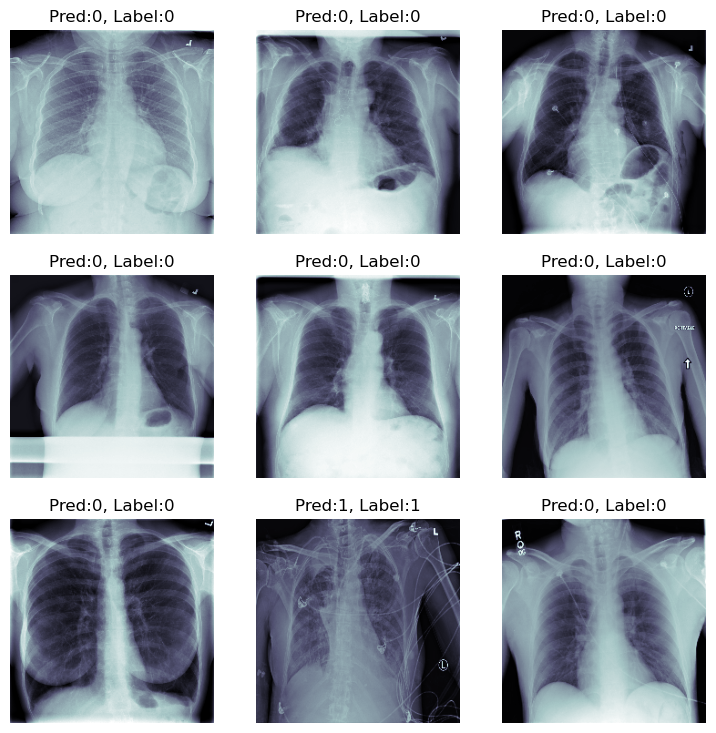

In [10]:
# Getting few images with model prediction 
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")
